# APPM Final Project

Justus Tulowiecki & Samuel Radack

# 

# Introduction

While state-of-the-art object detection models have proven their ability to detect objects in images and videos, they have often been too slow for real-time detection. For example, two stage objection models like Faster R-CNN have impressive results in terms but of mAP but can only detect objects at 17 frames per second using ZF net as the backbone model [1]. This problem is only exacerbated when adding the task of binary segmentation for the object. With improvements in single-stage detectors such as YOLOv2 [2], we aim to examine models that can bring us closer to real-time detection and tracking. For this reason, we focus on single-stage detectors which tend to have less parameters, and therefore greater speed. 

We narrow our focus to two object detection models--Yolov2 and Fully Convolutional One-Stage Object Detection (FCOS) [3]. YOLOv2 is an improvement on the original model, YOLOv1 from the paper, "You Only Look Once: Unified, Real-Time Object Detection". The purpose of the model was to improve the speed through the use of unified detection. By reasoning with classes and features in a single neural network, YOLOv2 is able to only use 8.52 billion operations for a forward pass. While it does sacrifice some accuracy for speed, YOLOv2 was able to accomplish a mean average precision of 78.6 while having a frame rate of 40. FCOS is an anchor free object detection model capable of achieving 46 FPS and 40.3 AP on COCO minival when using ResNet 50 as a backbone, and presumably greater frame rates. While frame rates are not provided for MobileNetv2, the inference time is presumably much faster, however, we do know that it has a lower average precision of 33 AP on COCO minival. While testing our models we are able to confirm these results, which we will discuss later.

For the task of object tracking we consider Siam Mask and Simple Online Realtime Tracking (SORT). Siam Mask is a siamese network that can produce rotated bounding boxes, a binary segmentation mask, and can perform object tracking. For this reason, we found this model architecture very attractive--providing features many other tracking models cannot provide while boasting an impressive 55 frames per second at evaluation time. While we examine its architecture and provide preliminary coding for the model we ultimately decided not to pursue this architecture due to the amount of time it takes to sufficiently train the model. On the other hand, SORT provides a fast and effective method for online object tracking, albeit with less features. The appeal of this algorithm is in the name itself, it's simplicity allows for evaluation over 100 frames per seconds. Since there is no network to be trained, it is lightweight and efficient and is largely limited by the quality and speed of the object detection model. While another variant exists that is more accurate (Deep SORT) we only consider SORT for it's ease of implementation in conjunction with its performance.


For our data we consider the MS COCO and Pascal VOC 2012 and 2007 datasets. Initially we considered MS COCO as it is the "gold standard" when it comes to object detection datasets. While we initially tried training models on MS COCO in hopes of reproducing results found from the models we examined, we ultimately ended up using VOC to trail and evaluate all of our models. Fine-tuning on COCO took about one day per iteration, of which we needed two to fine tune our models. For this reason we switched to find tuning on VOC which would give decent results in just several hours.



Sources:

[1] Ren, Shaoqing, et al. "Faster r-cnn: Towards real-time object detection with region proposal networks." Advances in neural information processing systems. 2015.

[2] Redmon, J., and A. Farhadi. "YOLO9000: Better, faster, stronger. arXiv 2016." arXiv preprint arXiv:1612.08242 (2016).

[3] Tian, Zhi, et al. "Fcos: Fully convolutional one-stage object detection." Proceedings of the IEEE international conference on computer vision. 2019.

# Literature Review
## Detection Models
### FCOS

FCOS is a Fully Convolutional One Stage object detection model. When FCOS was first introduced, two-stage detectors were considered state-of-the-art models. However, FCOS showed that a fully convolutional single stage detector can produce very competitive results while being much faster. Additionally, FCOS does not incorporate pre defined anchor boxes or region proposals which drastically reduces parameters and computation time. This also gives FCOS an advantage over other single stage detectors like YOLO v2/v3 in that FCOS is more robust against changes in object size and aspect ratio. To get a better understanding of FCOS, let's briefly look at the model architecture:


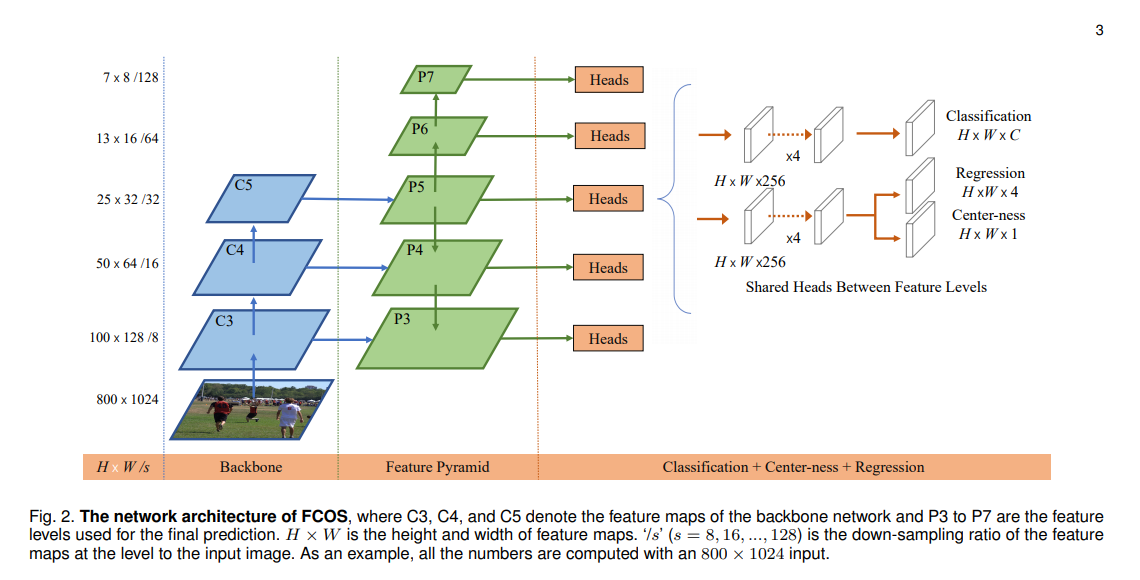


The backbone network is a network that is pre-trained on image net, such as ResNet50 and Mobilenetv2. Let's consider ResNet50 as our backbone. We feed forward an image through the network and store the last three feature maps. These feature maps are then fed into a feature pyramid to aid in detection at different scale. We then attach identical heads to each feature pyramid consisting of two branches--a classification branch and bounding box regression branch. Each branch consists of four 2 $\times$ 2 convolutions (parameters are not shared between the branches). The classification branch outputs a feature map of H $\times$ W $\times$ C where C is the number of classes. Likewise the regression branch outputs feature maps of identical spatial dimensions but two different heads:

1. A regression head with 4 channels representing the distances to the edge of the box from the center 
2. Centerness-head which, as the name implies, is the centerness of the box

Next, we move on to examining how FCOS performs compared to the state-of-the-art. The paper neatly summarizes the results in a chart that compares to current state-of-the-art methods at the time.

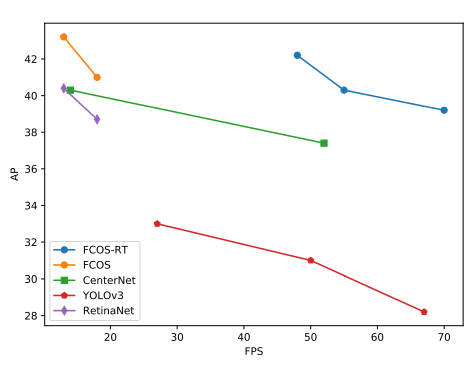

We see that the "original" form of FCOS performs extremely well, in terms of AP but is somewhat slow. To speed up the network they decreased the image size, which is denotes FCOS-RT (RT denoting "Real Time"). FCOS_RT beats YOLO v3 by a hefty margin, with an absolute difference of 10 points more AP while maintaining very high frame rates. With such high frame rates, we can expect a move closer to real time object tracking which has been challenging partly due to the speed and accuracy of object detection models. To summarize we ask: what are the advantages of the new method?
- Reusability with other FCN tasks such as semantic segmentation
- Proposal/Anchor free thus resulting in simpler computation and easier training
- FCOS can be used as region proposal networks in two-stage detectors for better performance
- State of the art performance


In this section, we will describe the implementation and evaluation of two detection models, YOLOv1 and R-CNN.

### YOLOv1

The model is based off the paper, "You Only Look Once: Unified, Real-Time Object Detection" which was published in 2015 and written by Joseph Redmon, Santosh Divvala, Ross Girshick, and Ali Farhadi. The paper has been cited over 12000 times.

The paper can be found at: https://arxiv.org/pdf/1506.02640.pdf

One interesting aspect of the YOLO model is unified detection. Separate components of objects detection are put into a single neural network. Features from the entire images are used to predict each bounding box. All bounding boxes for all classes in an image are predicted simultaneously. This means that the network reasons globally about the image and its objects. Becauses of this the model can be trained end to end and maintain a good mean average precision while still being fast. The model divides each image into a square grid. The grid cell that contains the center of an object is “responsible” for detecting that image. Each grid cell predicts a set B number of bounding boxes as well as confidences for the existence of an object and accuracy of the bounding boxes. That confidence is modeled as the probability of an object multiplied with the intersection over union with the ground truth. If there is no object in the underlying ground truth, then we would expect the confidence to be set to zero. The bounding boxes consist of five measurements: the center x coordinate, the center y coordinate, the width, the height and the confidence. Conditional class probabilities are also predicted based on the confidence of an object existing within a given cell. At test time class specific confidence scores are given for each grid cell which produces such visualizations as the one below. In the paper they used a 7 x 7 grid, two bounding boxes per cell and there are 20 classes in the VOC dataset.


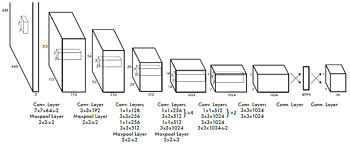

The network consists of 24 convolutional layers. Alternating 1 x 1 and 3 x 3 layers helps reduce the feature space of the image. Following the 24 convolutional layers there are two fully connected layers.  The initial convolutional layers extract features from the image. The fully connected layers output class probabilities and bounding box coordinate predictions. They also trained a fast version of YOLO (Fast YOLO). Fast YOLO has nine convolutional layers with few filters. This alternative model was built to push the capabilities of real time object detection. The architecture of the network is shown above.

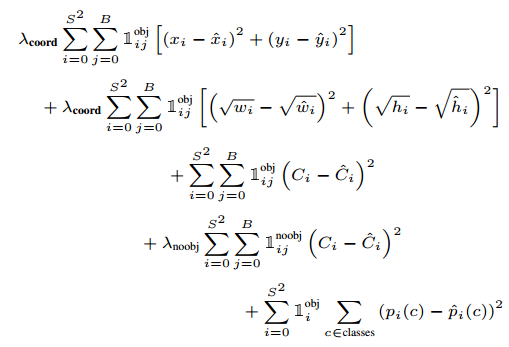

The above loss function is used for optimization during training. $1_{obj}$ represents the existence of an object within a grid cell. Grid cells are represented by $i$. The bounding boxes responsible for objects in a grid cell are represented by $j$. Classification error penelization only occurs if an object is present in that grid cell. Similarly, bounding box penalization error only occurs if the bounding box is “responsible” for predicting an object. 

As with training, inference only requires one network evaluation. There are 98 bounding boxe predictions per image with class probabilities on PASCAL VOC. The grid predictors enforce spatial diversity for bounding boxes. Objects near the border of multiple cells can be well localized by multiple cells. This can be fixed with non-maximal suppression. Non-maximal suppression adds two to three percent mean average precision.  

YOLO is limited for many reasons, one of which is the bounding boxes per image are limited by the grid size and the bounding boxes per cell. This makes it difficult to detect small objects and groups of objects. New or unusual aspect ratios and configurations can also cause problems for the network. The final limitation is due to the equal weighting of errors from small and large bounding boxes.


## YOLOv2

YOLOv2 and its variation YOLO9000 were built with three goals in mind: better, faster and stronger.  One issue the paper raises with object detection is that the classification aspect of the models is limited by the common datasets used such as VOC. In an ideal world, they want the range of classes to be as vast as that of image classification models. In an effort to accomplish this, they combine discrete data sets into a conglomerate. The moniker “YOLO9000” is based on the fact that 9000 classes are used.

One way they wanted to make YOLOv2 better was to improve the recall and localization errors that existed so prevalently in YOLOv1. Because they did not want to slow down the network, they had to devise a way to improve accuracy without using the normal means such as making it larger or deeper. One concept they used was batch normalization. Through the use of this concept on the convolutional layers, they saw a 2% increase in mean average precision while also reaping the benefits of regularization. This meant they could remove the dropout layers and not suffer from overfitting. Another method they use is training a high resolution classifier for the initial epochs before training for detection. This leads to a 4% increase in mean average precision. They also tried using anchor boxes which made the mean average precision slightly worse, but improved the recall which shows room for improvement. To choose the initial dimensions of the anchor boxes, they use k-means clustering. Direct location prediction for the anchor boxes were used as opposed to offsets. This stabilizes the network by constrain the location prediction and results in a 5% increase in mean average precision. Another change to this model is the use of a 13 by 13 grid, whereas the original used a 7 by 7 grid. To detect smaller objects, the model concatenates high resolution features and low resolution features. The resulting feature map is 13 by 13 by 2048 which is concatenated to the original feature map and allows the classifier to access fine grained features. A final feature that was added to YOLOv2 to make it better was Multi-Scale training. YOLOv1 was trained on 480 by 480 images. In the second version the image scales were randomly changed every 10 batches ranging from 320 by 320 to 608 by 608. This adaptability allows the network to run quickly wit low resolution images, and run highly accurately with high resolution images.

In an effort to make YOLOv2 faster the paper proposes a new classification network, Darknet. Darknet uses 3 by 3 convolutions like many detection frameworks prior. Similarly, the number of channels is doubled after every pooling step. Learning from Network in Network, they use global average pooling to make predictions and 1 by 1 convolutions in between the 3 by 3 convolutions to shrink the feature representations. Darknet only needs 5.58 billion operations to process an image yet it 72.9% top-1 accuracy and 91.2% top-5 accuracy. Training is done first for classification and secondly for detection.

To make the model stronger they propose a strategy to train on classification and detection jointly. When training they combine datasets for detection and classification. If a detection image is passed through, it will  backpropagate loss through the entire architecture of the model. If it is a classification image, it will backpropagate loss only through the classification specific part of the model architecture. To combine datasets they encountered a problem with the labeling. Classification datasets tend to be more specific than detection datasets. For example, while a detection dataset may classify all dogs as “dog”, a classification dataset could have hundreds of breeds of dogs and a dog may have to be classified as one of those breeds. To fix this problem they created a word tree which in essence relates each object to a “physical object” root. This path is then traversed the opposite way during detection to classify the image, taking the path of most confidence. YOLO9000 gets a mean average precision of 19.7% which is impressive if you consider it is classifying 9000 classes in real-time.


## Tracking Models

### Siam Mask

Source: https://arxiv.org/pdf/1812.05050.pdf


Siam Mask aims to perform both object tracking and segmentation in real time using an offline training approach and a single bounding box instantiation. Siam Mask is able to produce rotated bounding in conjunction with the object segmentation. At evaluation time, object tracking is done online and can reach speeds of 55 frames per second. Previous methods have been computationally expensive, and have lacked the ability to track and create a binary segmentation mask for the object specified in the inital frame. To accomplish this task one network is trained on three tasks:

1. Measure similarity between between target object and multiple candidates
2. Bounding Box regression
3. Binary Segmentation (binary labels not required during online segmentation and tracking)

To visualize the network, consider the following figure:

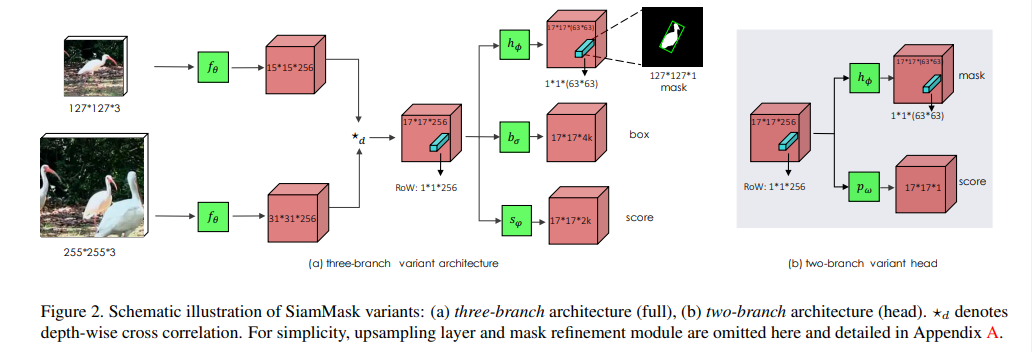

An image explar of 255x255 pixels and a search image of 127x127 pixels is passed into the network. Depthwise-cross correlation is performed to obtain responses of candidate windows (i.e. the spatial elements of the feature maps) which encodes similarity between the images. The result is a 17x17x256 feature map which is fed into the three branches for a binary segmentation mask, bounding box, and a classification score. The backbone network is ResNet-50 up until the final convolution of the 4th stage and the convolutions with stride of 2 are replaced with dilated convolutions to increase the receptive field.

While being relatively fast during online evaluation, we proposed this as a network to attempt object tracking. However, while coding the model and looking at the data required we realized that this model is not friendly to a home setup. For example, the training data spans multiple datasets: Youtube VOS, MS COCO, and the DET dataset. We have included the code we produced for Siam Mask, but for the previous reasons have decided not to continue with its use in our project. We turn our attention to the following algorithm SORT, which is a fast, efficient, and non neural-network approach to object tracking.

### SORT

The algorithm is based off of the paper, "Simple Online and Realtime Tracking" by Alex Bewley, Zongyuan Ge, Lionel Ott, Fabio Ramos and Ben Upcroft. It was published in 2016 and has 624 citations.	

The paper can be found at: https://arxiv.org/pdf/1602.00763.pdf


The first step in object tracking is object detection. The state of each model is represented by $x = [ u , v , s , r , u^1 , v^1 , s^1 ]^T$.  Here, $u$ and $v$ are the horizontal and vertical locations of the center pixel of the target. Next, $s$ and $r$ denote the scale and aspect ratio of the bounding box of the target. The aspect ratio is considered to be constant over time. If a detection is associated with a target, then the Kalman filter solves for the velocity optimally using the detected bounding box. If there is no detection associated with a target, then its prediction is solved for using the linear velocity model. This assumes constant movement, but could be helpful if a target has moved out of frame.

When assigning a new detection to an existing target, the bounding box of the target is estimated by predicting the target's new location in the frame. The assignment cost matrix is computed using the intersection over union distance between each detection and the bounding boxes. There is a minimum intersection over union threshold imposed to reject poor assignments.  The assignment is then solved using the hungarian algorithm. 

Each time an object enters or exits the frame, unique identities for it need to be created or destroyed respectively. If the intersection over union reaches a minimum threshold, then an object begins to be tracked.. The velocity of said object is initialized at zero. The covariance of the velocity is set to a large value to incorporate the unknown qualities of the object’s velocity. There is also a period of time in which the new object is scrutinized to see if it is indeed a target, or if it is simply a false positive. If an object has not been tracked for a specified amount of frames, it is terminated. This prevents the number of trackers from unbound growth. In the paper, they set the amount to one frame. This boosts efficiency by limiting the amount of trackers. They also do it because they are primarily concerned with frame to frame tracking. If an object reappears, it will simply be reidentified.

## Misc

### Non-Local Block

Source: https://openaccess.thecvf.com/content_cvpr_2018/papers/Wang_Non-Local_Neural_Networks_CVPR_2018_paper.pdf

Here I am very briefly going to explain one of the modifications we decided to test to our network--the non local block. In particular, we will examine the gaussian version of the block. The non-local block is as the name implies, it can incorporate global information in a network which is useful as convolutions are only able to capture local information until deeper layers. The visualization of the block is as follows:

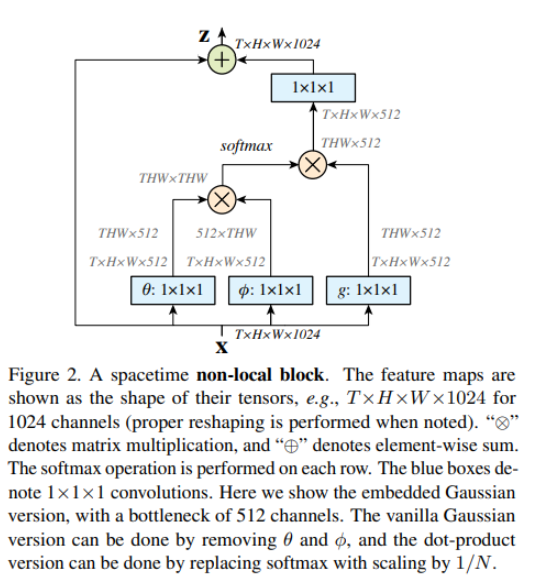

For the gaussian version $\theta$ and $\phi$ are simply the data of dimension HxWx512 (we ignore T here as we will only consider the case of working with images). We reshape the data and take the dot product to obtain the dot-product similarity. This is fed into a softmax to normalize the output. From here, we multiply the output with data that has passed through a 1x1 convolution with 512 output channels. This output passes through a final 1x1 convolution to adjust the output channels to 1024, where it is then added element-wise with a residual connection.

# EDA

In this next section, we will give a brief background on the datasets we will be exploring for object detection.

### MS COCO
Paper and full details located at: https://arxiv.org/pdf/1405.0312.pdf

Here we will perform exploratory data analysis on the popular Common Objects in Context dataset for object detection. First, a brief background on the dataset. COCO was released in 2014 with the goal of solving three problems:
1. Detection non-canonical perspectives of objects, e.g., objects not in center of frame and at a large scale.
2. Contextual reasoning between objects
3. Precise 2D localization of objects

Past datasets often ignored these issues that exist in the real world, where an object may be partially occluded or in the background of an image. The dataset contains multiple tasks: detection, pose estimation, keypoints, image captions, instance segmentation, and panoptic segmentation. For our purposes, the object segmentation/detection has 80 categories to be classified. Below is an example of an image from the dataset.

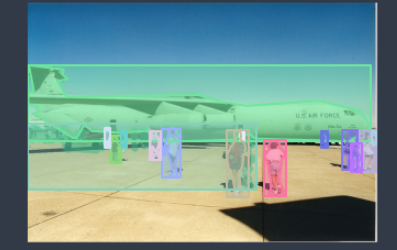

As one might suspect from looking at this image, the classes of objects are highly imbalanced in the dataset. Consider the following plot:

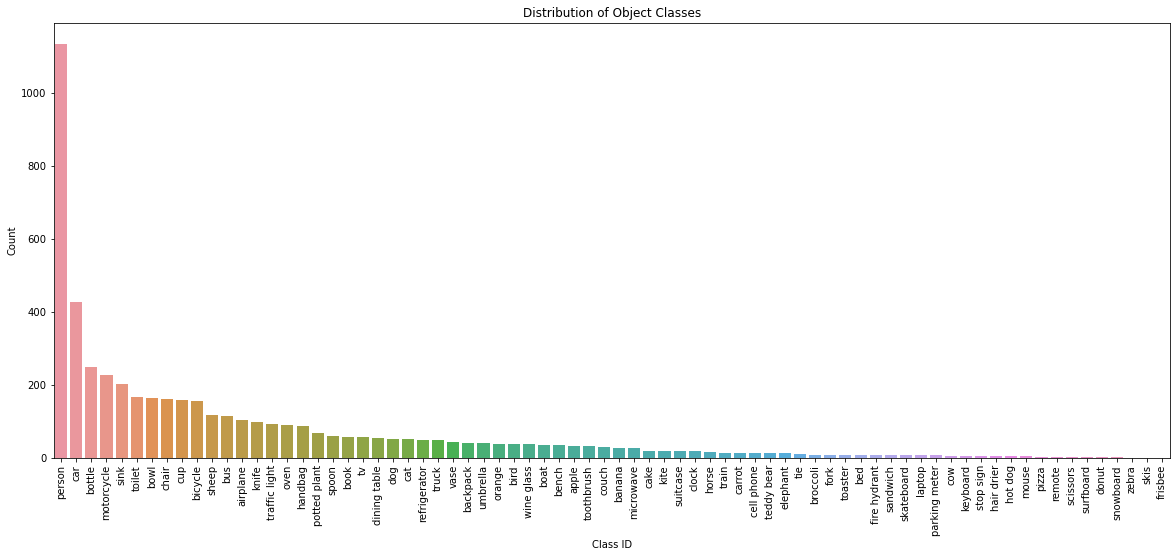

We see that people overwhelmingly make up the majority of the dataset and are twice as frequent than the even the next most frequent object (cars). This could suggest that data augmentation and mining for hard examples can be useful. An object like zebra, which is rare in COCO, could be oversampled with augmentation to make up for the lack of its frequency. 

Another important consideration is the distribution of the size of images. While images are often resized for training, we learned that image/object size can be great importance when training a deep learning model. One of the models used in this project, FCOS, has a parameter that looks for images between size ranges, thus, the size of the images and objects do matter! To analyze image size we generated this plot:

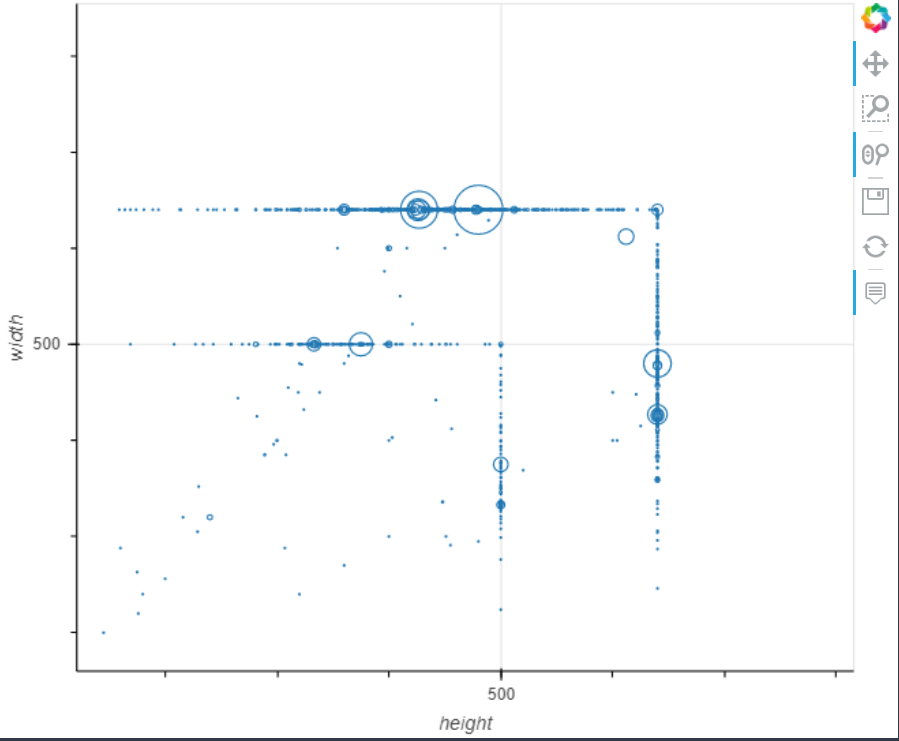

We see that the majority of images fall within two ranges of pixel height and width. There is a distinct pattern of images with a width of 500 or a height of 500 and similarly with height and width of 650

### PASCAL VOC

We perform a similar analysis for the Pascal VOC dataset. VOC itself is actually quite old, dating back to 2005 and contained only 4 classes, 1578 images, and 2209 annotated objects. The challenge has evolved over the years, and so has the data used. For the 2012 (most recent) version, there are 20 classes with 11,530 images, 27,450 regions of interest and 6,929 segmentations.

Let's start off by looking at an example from the VOC dataset. 

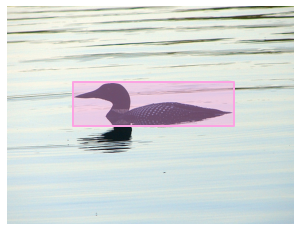

Looking at the distribution of classes below, we see a similarity VOC has with COCO--that is that people are the most common class. Cars are the second most populous class for each dataset. Notice that VOC has far fewer categories (20) to classify, thus making it a far less complex dataset.

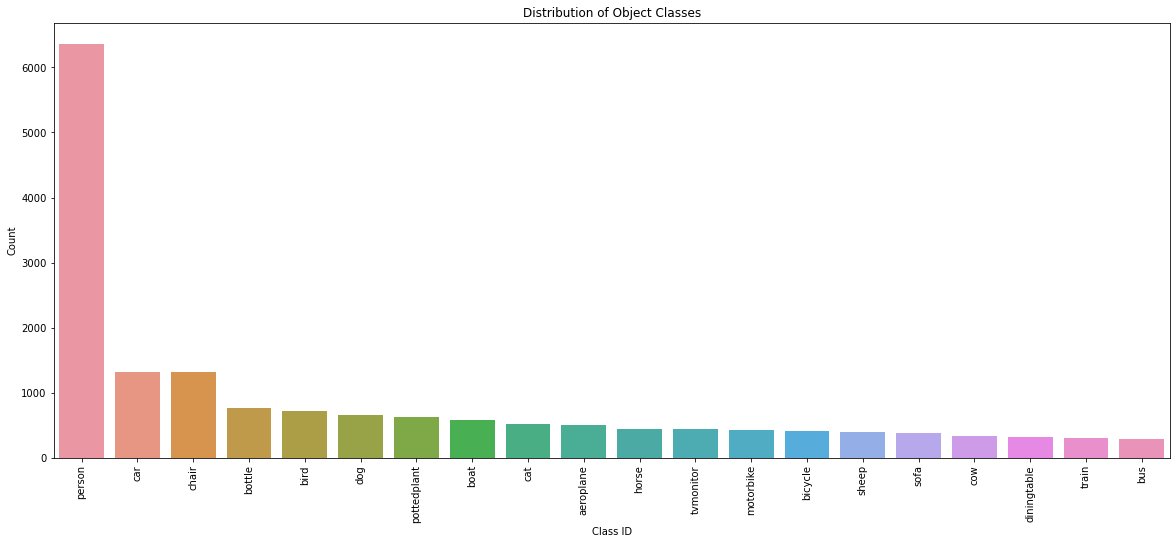

Looking at the pixel distribution size, the images are overall smaller than COCO with the max size being 500x500. The vast majority of images have a height or width of 500 with few images having smaller dimensions. This dataset would be great for proof-of-concept as the image sizes and categories are far less than COCO, making training far simpler. 

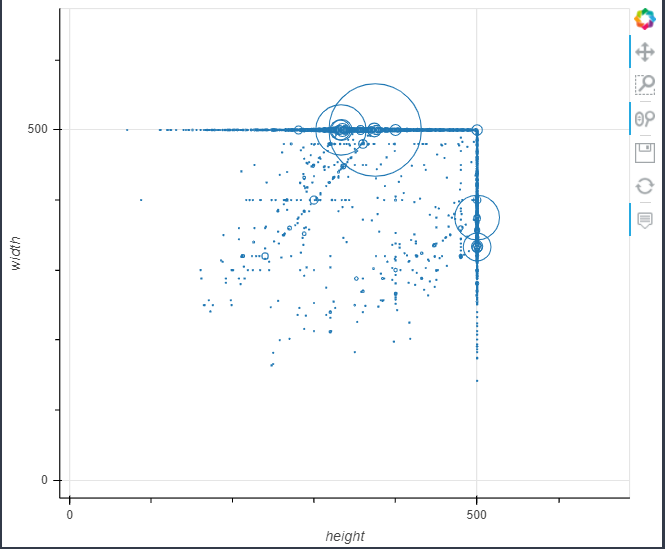

# Models
Sources used: https://github.com/tianzhi0549/FCOS, https://github.com/VectXmy/FCOS.Pytorch, https://github.com/uvipen/Yolo-v2-pytorc

#### YOLOv2

Our implementation of YOLOv2 was not the YOLO9000 version due to our resource limitations. The model has 22 convolutional layers and a residual connection. The predictions are made using the final convolutional layer. The baseline parameters used during training were:

Optimizer = Stochastic Gradient Descent

Epochs = 50

Learning Rate = 1e-5

Decay = 5e-5

Dropout = 0.5

Batch Size = 10

Momentum = 0.9

#### FCOS

For our other object detection models, we decided to use FCOS for its speed and competitiveness with YOLOv2. For our backbone model, we use ResNet 50, however, we “cut off” the end of the network so we are left with block 5 as our last layer (or layer 4 if using pre-trained PyTorch code). The heads of the network are kept the same as the literature. The model parameters are as follows:

Optimizer = Adam

Epochs = 20

Initial Learning Rate = 5e-5

Ending Learning Rate = 1e-6

Cosine Learning Rate Decay

# Results

Include that FPN placement matters, for mobilenet the early FPN layers are placed too early. Resnet


 suggesting that FCOS seems to suffer from networks that are not very deep or wide despite both backbone models having state-of-the art performance on ImageNet. For example, if consider the depth of network in terms of when we downsample that's what matters. ResNet has processed far more feature maps before each downsample
 
 
 pre-trained shufflenet 1.5 and 2x would be nice to have--no pretrained models available for pytorch

### FCOS

For out results, we consider the "base" version of FCOS in the paper which uses ResNet 50 as a backbone. Results for testing other architectures and features will be found in the ablation section of our project. Code to produce these results can can be found in FCOS/FCOS.Pytorch/model/Base FCOS.ipynb, and the results were aggregated outside of Python into a table for better readability. All of the following numeric charts and tables can be found in our notebook "Data Aggregation".

Our basline model obtained a mAP of 0.501, which is by far the best compared to our other models. To get a better idea of where our model struggles, we examined the average precision by class (below).

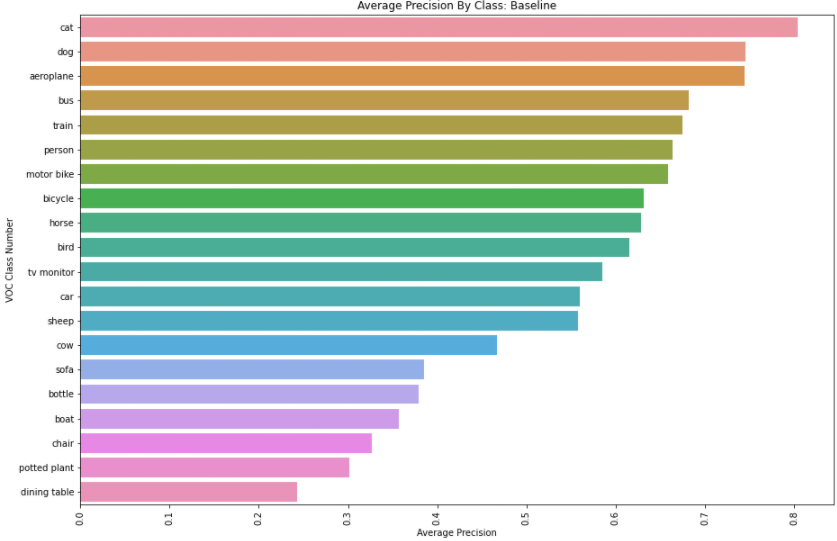


Interestingly, while VOC is vastly made up of the class "person" we see that person is not the most easily identifiable class. While we acknowledge greater frequency does not necessarily mean better accuracy, we did expect some correlation. Compared to our class frequencies in our exploratory data analysis, this would suggest that little correlation exists between class frequency and performance. We suspect that feature structure is far more important than frequency and with enough passes through the data, these differences can be sufficiently learned. For qualitative results we provide the following images (Generated from previously mentioned Base FCOS notebook)  

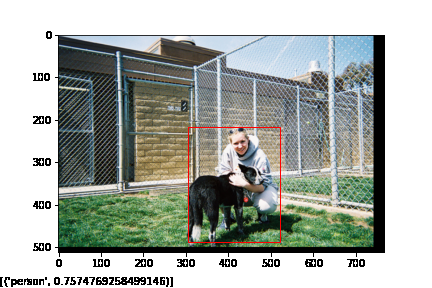

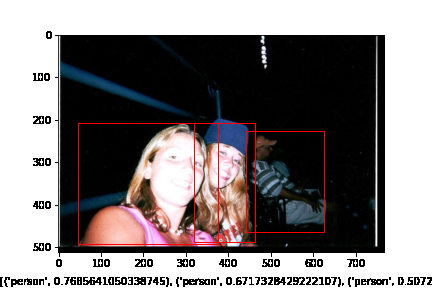

From these two images, we see that our model captures people well, even with drastically different lighting. However, the model fails to pick up the dog in the first image, suggesting that maybe we the model is missing some objects that overlap.

# Ablation

After looking at out baseline results we performed ablation studies. These included the following:

1. Adding a Non Local Block to the baseline model
2. Changing the backbone network from ResNet 50 to ShuffleNet v2
3. Changing the backbone network from ResNet50 to MobileNet v2
4. Addition of a non-local block in the backbone network
5. Addition of a non-local block into the FCOS detection heads
6. Removal of centerness

It should be noted that 3, 4, and 5 above are performed with MobileNet v2 as the results from 2 were comparable (although slightly worse) to ResNet but the training time was significantly faster.

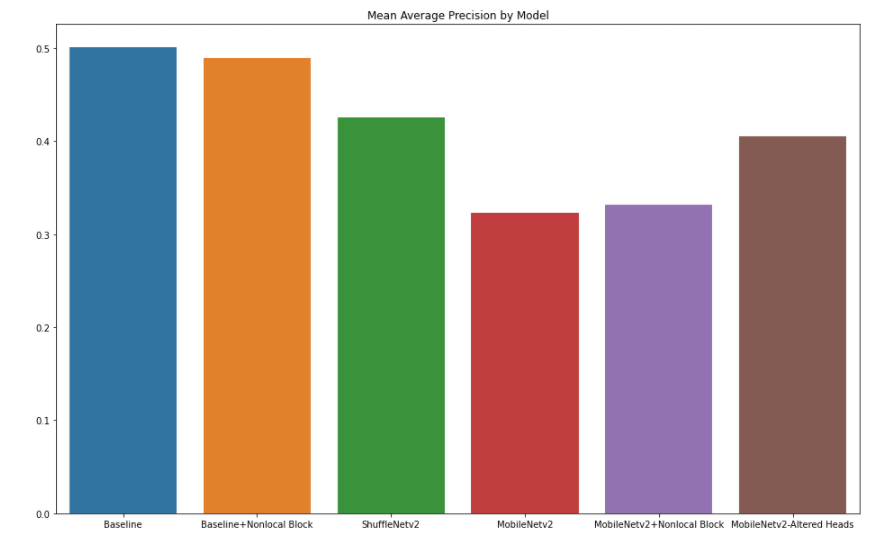


## Challenges, Failures, and Lessons Learned

Throughout our project we encountered many challenges and would like to take a brief moment to reflect on them.

#### Challenge #1: Working with Object Detection Meta Data

While model coding was mostly straightforward, the code to prepare the object detection data was vast and far more complex than the code for our models. We aimed to take pre-written functions to prepare the data and bounding boxes, but even incorporating this code proved challenging due to differences in data formats and model input/outputs. In general, I think we set out expectations correctly when it came to working with the data from a perspective of image classification but going through this process made us realize that image detection is a much more nuanced task.


#### Challenge #2: Model Convergence and Training Times

For object detection, there are only a handful of high quality datasets compared to other tasks such as image classification. While we found a unique method to test object detection models by adding a banana to images and attempting to detect it, it would be hard to determine the overall viability of our models. This process would involve the banana to also be in places that would not make sense contextually, also contributing to the lack of realism. While training times would have been extremely fast, we opted for Pascal VOC to balance between training times and data complexity.

While we coded some of our own models were able to show that they were learning, they converged at a much slower rate and in general had difficulties converging. For this reason, we opted to use models from github and modify the code to include different blocks and architectures. Again, the biggest hurdle for testing changes to the model was training time. Sometimes you make a change and the model works correctly, but other times you may have a slight typo in your code or incorrect implementation. This results in hours of training with poor results, thus needing another iteration of training. For this reason, we see the importance of adding unit tests in the future for small changes and possibly training on subclasses of the data to demonstrate model viability through shorter training times.



#### Challenge #3: YOLOv1 and Mean Average Precision
Code taken and modified from: https://github.com/motokimura/yolo_v1_pytorch

Our original idea was to train YOLO version 1 from scratch. We decided to follow the implementation listed above. Setting up the training was difficult, but after wrangling the VOC data, we were able to train. Please see information on the implementation for training below.

###### Parameters used during training
Learning Rate Schedule:

Epochs 1 - 40: $0.001$ 

Epochs 41 - 75: $0.01$

Epochs 75 - 105: $0.001$

Epochs 105 - 135: $0.001$

Weight Decay: $0.00005$

Momentum: $0.9$

Epochs: $135$

The model took approximately 8 hours to run.

After training, the next task ew encountered was displaying prediction outputs from the model. We struggled to find a way to implement the required decoding and non maximum suppression for the output tensors. After much trial an error we were able to create outputs for single images as can be seen below. The predicted bounding boxes were not ideal, especially considering that there were decent proposed bounding boxes for the image.

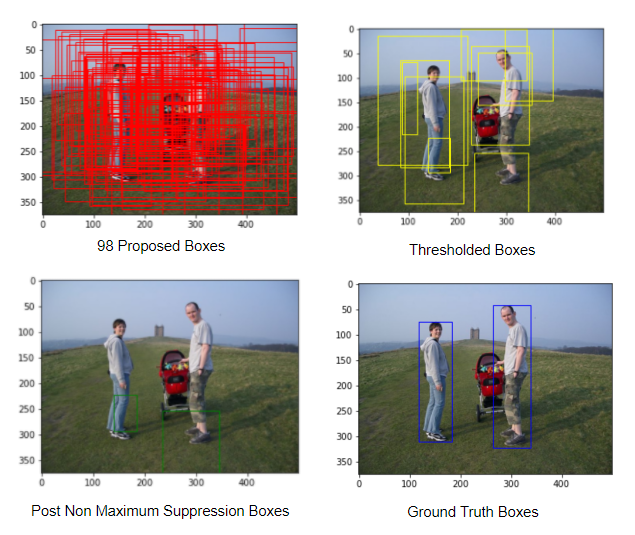!

Our final problem, and the reason we did not further pursue exploration of YOLO version 1, was that we were not able to evaluate the model. This complication may have been rooted in the disorganization of our testing data. VOC withholds their true testing annotations. Therefore, we were using the validation images and annotations. It was difficult to convert the annotation XMLs into usable file. One particular issue we encountered was that the class labels were not translating correctly when we attempted to extract them from the files. Either only a few labels were chosen or the only label that was chosen was "person". Unfortunately this means we were not able to gauge the success of this particular model.

#### Challenge #4 Non-Local Block In FCOS Detector Heads

Looking back on this failure makes the idea seem somewhat obvious. When incorporating the non-local block into the prediction heads of FCOS many memory errors were obtained, and thus a very small batch size had to be used. Additionally, when being trained the loss often diverged and we encountered exploding gradients. Despite this failure, I think it shows the importance of both trial and error as well as asking the question "what am I really trying to accomplish with this?" Putting the non-local block in the detector heads would likely introduce some redundancy since FCOS contains a feature pyramid network. In the feature pyramid network, we are already sharing some non local information between the different layers through top-down connections. What would make more sense is to include the non-local block before the feature pyramid network to better capture non-local information (but this seems somewhat redundant). We attempted to clip the gradients to provide a more stable training process, but this effort did not help. 

# Conclusions

We were a bit disappointed with the results of our detection models. Our implementations of the YOLO architectures yielded below our expectations qualitatively. Considering neither of us had experience with detection models, this is not entirely surprising. The use of lighter backbone models such as MobileNet v2 led to a slight decrease in the detection accuracy but improved the speed of training drastically. This tradeoff is an important one to consider, especially when tracking networks are taken into account. Generally, our addition of a nonlocal block was not successful in boosting the performance of our detection. When we reduced the parameters of some of our models slightly, we achieved better results in a shorter training time. This could be due to the use of a smaller dataset (VOC) than MSCOCO which in turn would mean less parameters are necessary. 

Going forward, we would proposal several changes given the opportunity. We would have liked to explore YOLO 9000 to obtain sub-classes for our object detections. However, we were unable to find a pre-trained model on ImageNet for PyTorch. Furthermore, we would like to experiment with a version of ShuffleNetv2 that has more channels as ShuffleNet v2 has proven to be even faster than MobileNetv2. Again, the limiting resource here was finding a pre-trained model for PyTorch. Ideally, we would have also trained on MS COCO, however, we found that throughout the project we were consistently limited by training times and the power of our GPUs. We were able to run a couple models with MS COCO on CU Boulder’s Research computing Blanca nodes, but given low priority we found it extremely difficult to obtain computing time. When we did have computing time, we were further limited by a computing time limit which was insufficient to obtain the needed iterations on the COCO dataset.